In [0]:
import numpy as np
import pandas as pd
import scipy.linalg
import scipy.sparse as sp

import jax.numpy as jnp
import jax.scipy as jsp
from jax import random, jit

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')

In [0]:
import jax, scipy

print('jax version:', jax.__version__)
print('numpy version:', np.__version__)
print('scipy version:', scipy.__version__)

jax version: 0.1.43
numpy version: 1.16.4
scipy version: 1.3.1


In [0]:
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


In [0]:
# @ref: https://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [0]:
get_available_gpus()

[]

# JAX demo

In [0]:
def slow_f(x):
  # Element-wise ops see a large benefit from fusion
  return x * x + x * 2.0

# use XLA to compile the function
fast_f = jit(slow_f)

In [0]:
x = np.ones((5000, 5000))
type(x) # numpy.ndarray

numpy.ndarray

In [0]:
%%timeit 
fast_f(x)

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:109: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


The slowest run took 20.42 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 54.6 ms per loop


In [0]:
%%timeit 
slow_f(x)

1 loop, best of 3: 152 ms per loop


In [0]:
x_j = jnp.ones((5000, 5000))
type(x_j)

jax.lax.lax._FilledConstant

In [0]:
%%timeit 
fast_f(x_j)

10 loops, best of 3: 37.8 ms per loop


In [0]:
%%timeit 
slow_f(x_j)

1 loop, best of 3: 149 ms per loop


# Full SVD for dense matrix

In [0]:
def jnp_svd(X):
    # Compute full SVD
    U, Sigma, Vh = jnp.linalg.svd(X, 
                                  full_matrices=False, # It's not necessary to compute the full matrix of U or V
                                  compute_uv=True,
                                 )
    return U, Sigma, Vh

def jsp_svd(X):
    U, Sigma, Vh = jsp.linalg.svd(X, 
                                  full_matrices=False,
                                  compute_uv=True,
                                  check_finite=False,
                                  overwrite_a=True
                                 )
    return U, Sigma, Vh
    

def np_svd(X):
    U, Sigma, Vh = np.linalg.svd(X,
                                 full_matrices=False,
                                 compute_uv=True
                                )
    return U, Sigma, Vh

def scipy_svd(X):
    U, Sigma, Vh = scipy.linalg.svd(X,
                                    full_matrices=False,
                                    compute_uv=True,
                                    check_finite=False,
                                    overwrite_a=True
                                )
    return U, Sigma, Vh

def scipy_gesvd(X):
    U, Sigma, Vh = scipy.linalg.svd(X,
                                    full_matrices=False,
                                    compute_uv=True,
                                    check_finite=False,
                                    overwrite_a=True,
                                    lapack_driver='gesvd'
                                )
    return U, Sigma, Vh
    

In [0]:
from time import time

def time_func(func, n_trials, *args, **kwargs):
    times = []
    for i in range(n_trials):
        t0 = time()
        res = func(*args, **kwargs)
        tt = time()
        t = tt - t0
        times.append(t)
    return np.asarray(times)

def time_svd_funcs(funcs, Ns=[200, 500, 1000, 2000], n_trials=7):
    results = []
    key = random.PRNGKey(42)
    for N in Ns:
        # generate random matrix as input
        X = random.normal(key, (N, N))
        for func in funcs:
            times = time_func(func, n_trials, X)
            
            results.extend([{
                'time': t, 
                'N': N,
                'func_name': func.__name__,
                } for t in times])
    return pd.DataFrame(results)

In [0]:
results = time_svd_funcs([np_svd, scipy_svd, scipy_gesvd], 
                         Ns=[200, 500, 1000, 2000]
                        )

In [0]:
results.shape

(84, 3)

In [0]:
results.groupby(['N', 'func_name']).agg([np.mean, np.std])

time          
                       mean       std
N    func_name                       
200  np_svd        0.022725  0.016504
     scipy_gesvd   0.045172  0.001424
     scipy_svd     0.015765  0.010344
500  np_svd        0.125901  0.004225
     scipy_gesvd   0.432476  0.003697
     scipy_svd     0.089805  0.000724
1000 np_svd        0.828589  0.024165
     scipy_gesvd   3.549135  0.053115
     scipy_svd     0.528527  0.003154
2000 np_svd        6.175623  0.053947
     scipy_gesvd  54.479678  0.221581
     scipy_svd     3.548271  0.027179

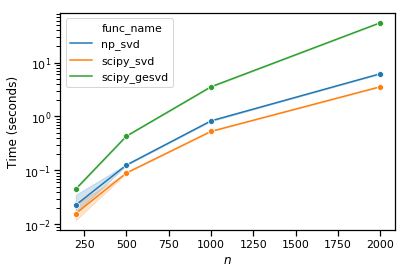

In [0]:
ax = sns.lineplot(x='N', y='time', hue='func_name',
                  marker='o',
                  data=results)
ax.set_ylabel('Time (seconds)')
ax.set_xlabel('$n$')
ax.set_yscale('log')
# ax.set_xscale('log')

In [0]:
results = time_svd_funcs([jnp_svd, jsp_svd, 
                          np_svd, scipy_svd
                         ], 
                         Ns=[200, 500, 1000, 2000]
                        )

In [0]:
results.groupby(['N', 'func_name']).agg([np.mean, np.std])

time          
                     mean       std
N    func_name                     
200  jnp_svd     0.007721  0.019959
     jsp_svd     0.000147  0.000024
     np_svd      0.194512  0.287473
     scipy_svd   0.204851  0.326828
500  jnp_svd     0.017467  0.045703
     jsp_svd     0.000112  0.000012
     np_svd      0.696224  0.310920
     scipy_svd   0.434062  0.406623
1000 jnp_svd     0.025031  0.065530
     jsp_svd     0.000114  0.000018
     np_svd      4.196005  1.273682
     scipy_svd   2.173959  1.418268
2000 jnp_svd     0.015669  0.041100
     jsp_svd     0.000110  0.000013
     np_svd     29.288250  1.871482
     scipy_svd  10.035229  6.609214

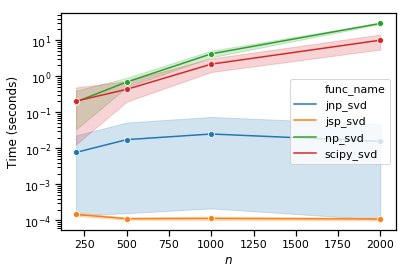

In [0]:
ax = sns.lineplot(x='N', y='time', hue='func_name',
                  marker='o',
                  data=results)
ax.set_ylabel('Time (seconds)')
ax.set_xlabel('$n$')
ax.set_yscale('log')

In [0]:
# Compute jax function with JIT
jit_jnp_svd = jit(jnp_svd)
jit_jsp_svd = jit(jsp_svd)

In [0]:
def time_svd(svd_func, n_trials=7, N=200):
    times = []
    for i in range(n_trials):
        # generate a random input matrix every trail to prevent 
        # jax from caching the results
        key = random.PRNGKey(np.random.randint(0, 1000))
        X = random.normal(key, (N, N))
        t0 = time()
        res = svd_func(X)
        tt = time()
        t = tt - t0
        times.append(t)
    return np.asarray(times)

def time_svd_funcs2(funcs, Ns=[200, 500, 1000, 2000], n_trials=7):
    results = []

    for N in Ns:
        for func in funcs:
            times = time_svd(func, n_trials, N)            
            results.extend([{
                'time': t, 
                'N': N,
                'func_name': func.__name__,
                } for t in times])
    return pd.DataFrame(results)

In [0]:
results = time_svd_funcs2([jnp_svd, jsp_svd,
                           np_svd, scipy_svd
                         ], 
                         Ns=[200, 500, 1000, 2000]
                        )

In [0]:
results.groupby(['N', 'func_name']).agg([np.mean, np.std])

time          
                    mean       std
N    func_name                    
200  jnp_svd    0.005765  0.005748
     jsp_svd    0.012088  0.000800
     np_svd     0.027077  0.021298
     scipy_svd  0.011653  0.000609
500  jnp_svd    0.038234  0.047313
     jsp_svd    0.090133  0.001279
     np_svd     0.183280  0.153448
     scipy_svd  0.100605  0.008528
1000 jnp_svd    0.227720  0.283698
     jsp_svd    0.529090  0.001541
     np_svd     1.149914  0.855303
     scipy_svd  0.551651  0.001443
2000 jnp_svd    1.525515  1.902691
     jsp_svd    3.551000  0.020982
     np_svd     8.322217  5.538444
     scipy_svd  3.665680  0.031148

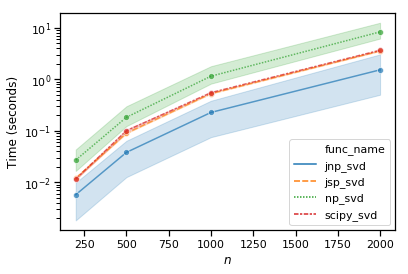

In [0]:
ax = sns.lineplot(x='N', y='time', hue='func_name',
                  style='func_name',
                  marker='o',
                  alpha=0.7,                  
                  data=results)
ax.set_ylabel('Time (seconds)')
ax.set_xlabel('$n$')
ax.set_yscale('log')